In [345]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import shelve
import random
import itertools
import omero
import scipy.cluster.hierarchy as hchy
from seaborn import clustermap

import pandas as pd
from pandas import Series,DataFrame,read_csv, merge,concat,read_hdf,HDFStore
from omero.gateway import BlitzGateway
from matplotlib.widgets import Slider
from matplotlib import gridspec
from sklearn.externals import joblib
from contextlib import closing

from sklearn import random_projection
import sklearn.neighbors as nn
import sklearn.manifold as man
import sklearn.decomposition as dec
from sklearn.preprocessing import scale,robust_scale
from sklearn.metrics.pairwise import euclidean_distances


%matplotlib nbagg
plt.rcParams['image.cmap']='gray'

#hard coded dirs
dbpath='/home/ubuntu/idr_homes/szleo/features/idr0008-rohn-actinome/screenB/output/'
dataDir='/home/ubuntu/data'
scratchDataDir='/scratch/rohnFeatures'


In [18]:
def getImIDs(plns, wells,fields):
    lids=list()
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()

        for pln,wstr,f in zip(plns,wells,fields):
        
            r=ord(wstr[0:1])-65
            c=int(wstr[1:])-1
            
#            print pln,wstr,f,r,c

            Q='''select well from Well as well 
            left outer join fetch well.wellSamples as ws 
            left outer join fetch ws.image as img 
            where well.plate.name = \'''' + pln+ '\' and well.row='+str(r)+' and well.column='+str(c)

            w=conn.getQueryService().findAllByQuery(Q,None)[0]
            im = w.getWellSample(int(f)-1).getImage()
            lids.append(im.getId().getValue())
    finally:
        conn._closeSession()
    
    return lids

In [19]:
def getMapAnnotationsAsDicts(imids):
    la=list()
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()

        for imid in imids:
            im= conn.getObject("Image",imid)
            a=im.getAnnotation()
            la.append(dict(a.getValue()))
    finally:
        conn._closeSession()
    
    return la

In [4]:
def db2pd(fin):
#from https://gist.github.com/manics/bc003272b038027faf653d576f3c9393

    # f = "plate1_1_013_5_features.db"

#    print "Opening %s" % fin
    with closing(shelve.open(fin, "r")) as f:
        values = list(f.itervalues())

    x = values[0]

    header_meta = []
    header_ft = []
    header_ftn = []
    # width_ft = []

    for k in sorted(x.keys()):
        v = x[k]
        if isinstance(v, list):
            header_ft.append(k)
            header_ftn.extend('%s_%02d' % (k, i) for i in xrange(len(v)))
            # width_ftn.append(len(v))
        else:
            header_meta.append(k)

    assert len(header_ft) == 124
    assert len(header_meta) == 11

#    print "Processing %s" % fin
    rows = []
    for vs in values:
        meta = [vs[h] for h in header_meta]
        ft = [vs[h] for h in header_ft]
        r = itertools.chain.from_iterable([meta] + ft)
        rows.append(list(r))

#    print "Creating dataframe %s" % fin
    df = DataFrame(rows, columns=(header_meta + header_ftn))

    #print "Saving %s" % fout
    #df.to_hdf(fout, 'wndcharm', complevel=9, complib='zlib')

    return df


In [258]:
def getRohnTile(imid,x,y,w,h,chan=0):
#    plateId,x,y,w,h,ti,tf=422,0,0,200,200,50,150
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()

        im = conn.getObject("Image", imid)
        pix=im.getPrimaryPixels()

        z=0;c=chan;
        tile = (x, y, w, h) 
        plane = pix.getTile(theC=c,tile=tile)
    finally:
        conn._closeSession()
    
    return plane

In [6]:
def goneFishing(df,qry,s2w,nbrs):
#    pln,x,y,t='plate1_1_013_5',504,384,220  #division at 220

#    qry=df[(df.x==x) & (df.y==y) & (df.series==se)].iloc[:,11:]

#    dfq=df[df.name!=pln]
    chan=0
    

#    hook=getRohnTile(imid,x,y,w,h,chan)    
    
    distances, indices = nbrs.kneighbors(qry)
    nnn=len(indices[0])
    d,r=divmod(nnn,4)
               
    w=df.w.iloc[0]
    h=df.h.iloc[0]
    tiles=np.zeros((h,w,nnn))
    for ind,ii in zip(indices[0],range(nnn)):
        try:
            secur=df.series.iloc[ind]
            x=df.x.iloc[ind]
            y=df.y.iloc[ind]
            imindcur=s2w[(s2w.PLATE==pln)&(s2w.SERIES==secur)].imIds.iloc[0]
            tiles[:,:,ii]=getRohnTile(imindcur,x,y,w,h,chan) 
        except:
            continue

    
    plt.figure(figsize=(12,12))

    imc=buildComposite(tiles,d+(1&r),4,smpl=1)
#    plt.figure(figsize=(12,15))
    plt.imshow(imc)
    

In [7]:
def buildComposite(st,n,m,smpl=None):
    #nxm shots from st in a grid, as an image
    nr=st.shape[0]
    nc=st.shape[1]
    if smpl==None:
        smpl=st.shape[2]/(n*m)
    res=np.zeros((nr*n,nc*m))
    for i in range(n):
        for j in range(m):
            try:
                res[i*nr:i*nr+nr,j*nc:j*nc+nc]=st[:,:,(i*m+j)*smpl]
            except:
                break
    return res

## preping data

In [14]:
#metadata: linking omero, features, annotations

s2w=read_csv(os.path.join(dataDir,'series_to_well.tsv'),sep='\t')
lids=getImIDs(s2w.PLATE, s2w.WELL,s2w.FIELD)
s2w['imIds']=lids
la=getMapAnnotationsAsDicts(s2w.imIds)
s2w['annotations']=la
s2w.to_csv(os.path.join(scratchDataDir,'series_to_well_IDAnnotation.tsv'),sep='\t')

In [8]:
s2w=read_csv(os.path.join(scratchDataDir,'series_to_well_IDAnnotation.tsv'),sep='\t')

In [327]:
gennpool=[]
for i,r in s2w.iterrows():
    try:
        a=r['annotations']
        gennpool.append(eval(a)['siRNA Pool Name'])
    except:
        gennpool.append('')
s2w['siRNA Pool Name']=gennpool
s2w.to_csv(os.path.join(scratchDataDir,'series_to_well_IDAnnotation.tsv'),sep='\t')

In [12]:
fout=os.path.join(dataDir,pln+'_features'+'.h5')
df.to_hdf(fout, 'wndcharm', complevel=9, complib='zlib')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:257: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis0] [items->None]

  f(store)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:257: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

  f(store)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:257: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block1_items] [items->None]

  f(store)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:939: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directl

## All .db to h5

In [11]:
s2w.PLATE.unique()[4:]

array(['Plate3_Actinome1', 'Plate4_Actinome1', 'Plate5_Actinome1',
       'Plate6_Actinome1', 'Plate7_Actinome1', 'Plate8_Actinome1',
       'Plate9_Actinome1'], dtype=object)

In [361]:
    pln='Plate10_Actinome1'
#for pln in s2w.PLATE.unique()[0]:
    print pln
    df=DataFrame()
    for s in range(s2w[s2w.PLATE==pln].SERIES.max()):
        fin=os.path.join(dbpath, pln,'116_86',pln+'_'+str(s)+'_features'+'.db')
        df=concat((df,db2pd(fin)))

    types = df.apply(lambda x: pd.lib.infer_dtype(x.values))
    for col in types[types=='unicode'].index:
        df[col] = df[col].astype(str)
        
    fout=os.path.join(scratchDataDir,pln+'_features'+'.h5')
    df.to_hdf(fout, 'wndcharm', complevel=9, complib='zlib',format='table')
    

Plate10_Actinome1


HDF5ExtError: HDF5 error back trace

  File "H5A.c", line 259, in H5Acreate2
    unable to create attribute
  File "H5Aint.c", line 275, in H5A_create
    unable to create attribute in object header
  File "H5Oattribute.c", line 347, in H5O_attr_create
    unable to create new attribute in header
  File "H5Omessage.c", line 224, in H5O_msg_append_real
    unable to create new message
  File "H5Omessage.c", line 1945, in H5O_msg_alloc
    unable to allocate space for message
  File "H5Oalloc.c", line 1142, in H5O_alloc
    object header message is too large

End of HDF5 error back trace

Can't set attribute 'non_index_axes' in node:
 /wndcharm (Group) ''.

In [349]:
for pln in s2w.PLATE.unique():
    print pln
    fout=os.path.join(scratchDataDir,pln+'_features'+'.h5')
    df=read_hdf(fout)
    types = df.apply(lambda x: pd.lib.infer_dtype(x.values))
    for col in types[types=='unicode'].index:
        df[col] = df[col].astype(str)
    df.to_hdf(fout, 'wndcharm', complevel=9, complib='zlib',format='table')
 

Plate10_Actinome1


AttributeError: 'NoneType' object has no attribute 'apply'

In [359]:
pln

'P'

## loading stuff

In [12]:
pln='Plate10_Actinome1'
fout=os.path.join(scratchDataDir,pln+'_features'+'.h5')
print fout

/scratch/rohnFeatures/Plate10_Actinome1_features.h5


In [3]:
s2w=read_csv(os.path.join(dataDir,'series_to_well_IDAnnotation.tsv'),sep='\t')
df=read_hdf(os.path.join(dataDir,'Plate10_Actinome1_features.h5'))

## DAPI PCA

In [13]:
pca= joblib.load(os.path.join(dataDir,'PCA_4condentationwells.pkl')) 

In [21]:
dfcond=read_hdf(os.path.join(dataDir,'PCA250features_testwells.h5'))

In [27]:
dfdapi=df[df.c==0].iloc[:,11:]
dfdapi=scale(dfdapi)
dfdapi=pca.transform(dfdapi)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [32]:
s2w.head()

,Unnamed: 0,PLATE,SERIES,WELL,FIELD,imIds,annotations
0,0,Plate10_Actinome1,0,A01,1,106449,{}
1,1,Plate10_Actinome1,1,A01,2,106759,{}
2,2,Plate10_Actinome1,2,A01,3,106760,{}
3,3,Plate10_Actinome1,3,A02,1,107217,{}
4,4,Plate10_Actinome1,4,A02,2,107218,{}


<IPython.core.display.Javascript object>


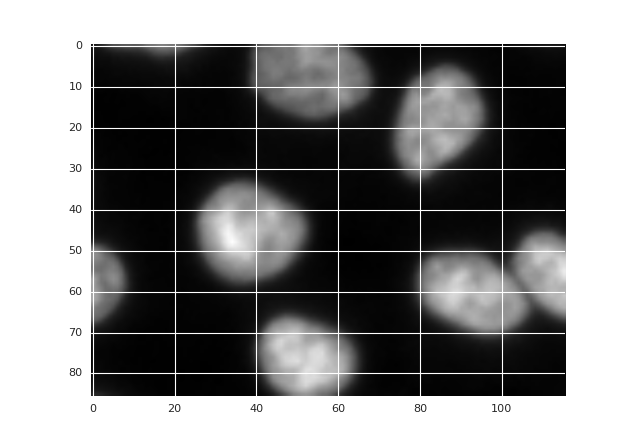

In [264]:
imid=random.choice(s2w[s2w.PLATE==pln].imIds.unique())
x=random.choice(df.x.unique())
y=random.choice(df.y.unique())
w=116
h=86
im=getRohnTile(imid,x,y,w,h,chan=0)
plt.figure()
plt.grid(False)
plt.imshow(im)

<IPython.core.display.Javascript object>


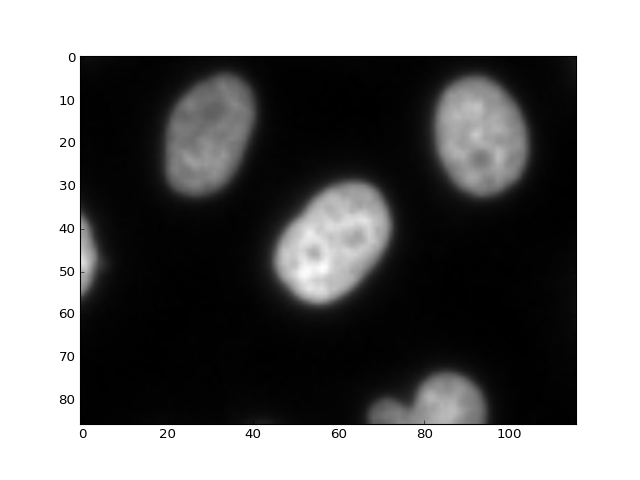

In [53]:

#pln,x,y,t='plate1_2_006_5',168,896,66  #division at 30 and 66

#at random
#x=random.choice(df.x.unique())
#y=random.choice(df.y.unique())
#t=random.choice(range(df.t.max()))
#pln=random.choice(df['name'].unique())

#dfq=df[df.name!=pln]
nbrs = nn.NearestNeighbors(n_neighbors=12, algorithm='ball_tree').fit(dfdapi) 




Traceback (most recent call last):
  File "/home/ubuntu/OMERO.server-5.1.4-ice35-b55/lib/python/omero/gateway/__init__.py", line 4160, in __call__
    return self.f(*args, **kwargs)
  File "/home/ubuntu/OMERO.server-5.1.4-ice35-b55/lib/python/omero_api_RawPixelsStore_ice.py", line 883, in getTile
    return _M_omero.api.RawPixelsStore._op_getTile.invoke(self, ((z, c, t, x, y, w, h), _ctx))
InternalException: exception ::omero::InternalException
{
    serverStackTrace = ome.conditions.InternalException:  Wrapped Exception: (java.lang.RuntimeException):
loci.formats.FormatException: Invalid tile size: x=0, y=435, w=116, h=86
	at ome.io.bioformats.BfPixelBuffer.getTileDirect(BfPixelBuffer.java:495)
	at ome.services.RawPixelsBean.getTile(RawPixelsBean.java:789)
	at sun.reflect.GeneratedMethodAccessor510.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at org.springframework

<IPython.core.display.Javascript object>


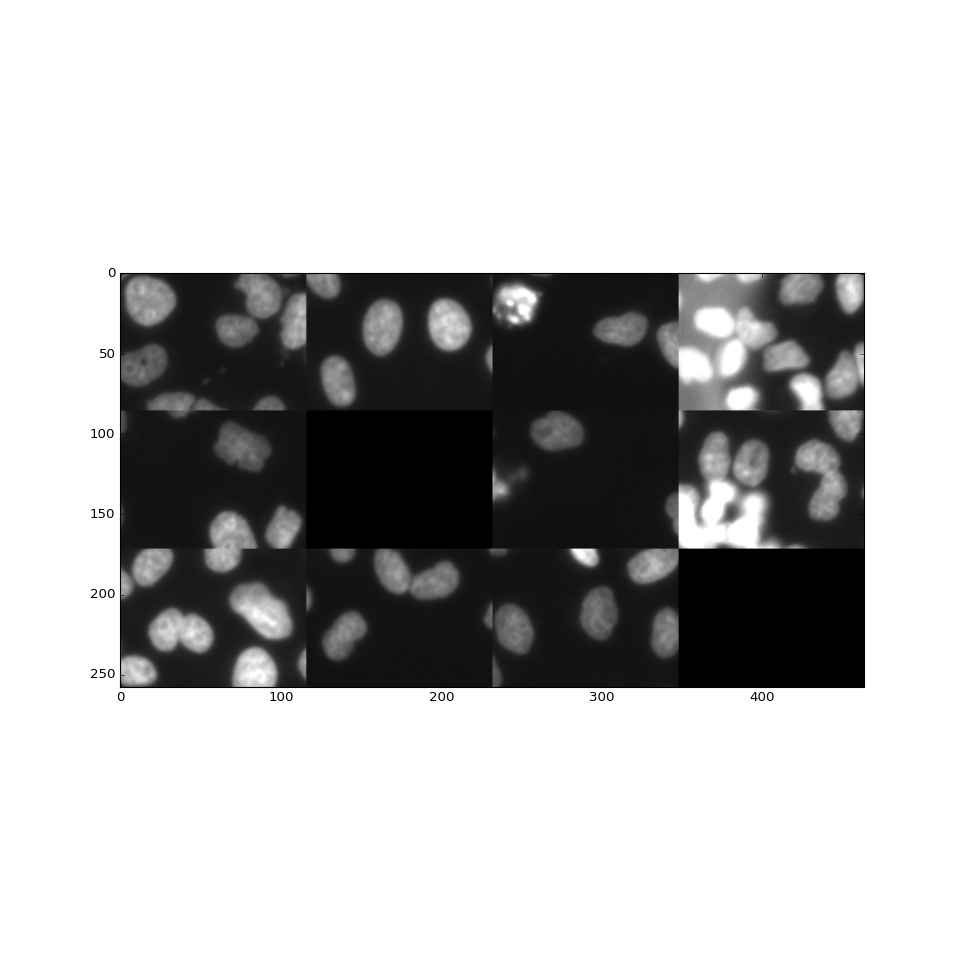

In [79]:
plncond,x,y,t='plate1_1_013_5',504,384,220  #division at 220

qry=dfcond[(dfcond.x==x) & (dfcond.y==y) & (dfcond.name==plncond) & (dfcond.t==t)].iloc[:,12:]
goneFishing(df,qry,s2w,nbrs)

## phenotype clustering

In [220]:
conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
connected = conn.connect()

In [198]:
ofId=4810255
original_file = omero.model.OriginalFileI(ofId, False)

openTable = conn.c.sf.sharedResources().openTable(ofile)
rowCount = openTable.getNumberOfRows()

In [203]:
#table to df

column_names = [col.name for col in openTable.getHeaders()]

black_list = []
column_indices = []
for column_name in column_names:
    if column_name in black_list:
        continue
    column_indices.append(column_names.index(column_name))

table_data = openTable.slice(column_indices, None)
data = []
for index in range(rowCount):
    row_values = [column.values[index] for column in table_data.columns]
    data.append(row_values)
    
dfRhonAnn=DataFrame(data)
dfRhonAnn.columns=column_names


In [204]:

#transforming phenotypes into one hot booleans
BoolCols=[]
PhenLab=[]
for col in dfRhonAnn.columns:
    if ('Phenotype' in col)&~('Term' in col):
        dfRhonAnn['Bool'+col]=~(dfRhonAnn[col] =='')
        BoolCols.append('Bool'+col)
        PhenLab.append(dfRhonAnn[col].unique()[1])

In [206]:
phenMap=dfRhonAnn.groupby('siRNA Pool Name')[BoolCols].sum()>0
phenMap=phenMap[phenMap.sum(axis=1)>0]
phenMap.columns=PhenLab
Z = hchy.linkage(phenMap, 'ward')
Zt = hchy.linkage(phenMap.transpose(), 'ward')


<IPython.core.display.Javascript object>


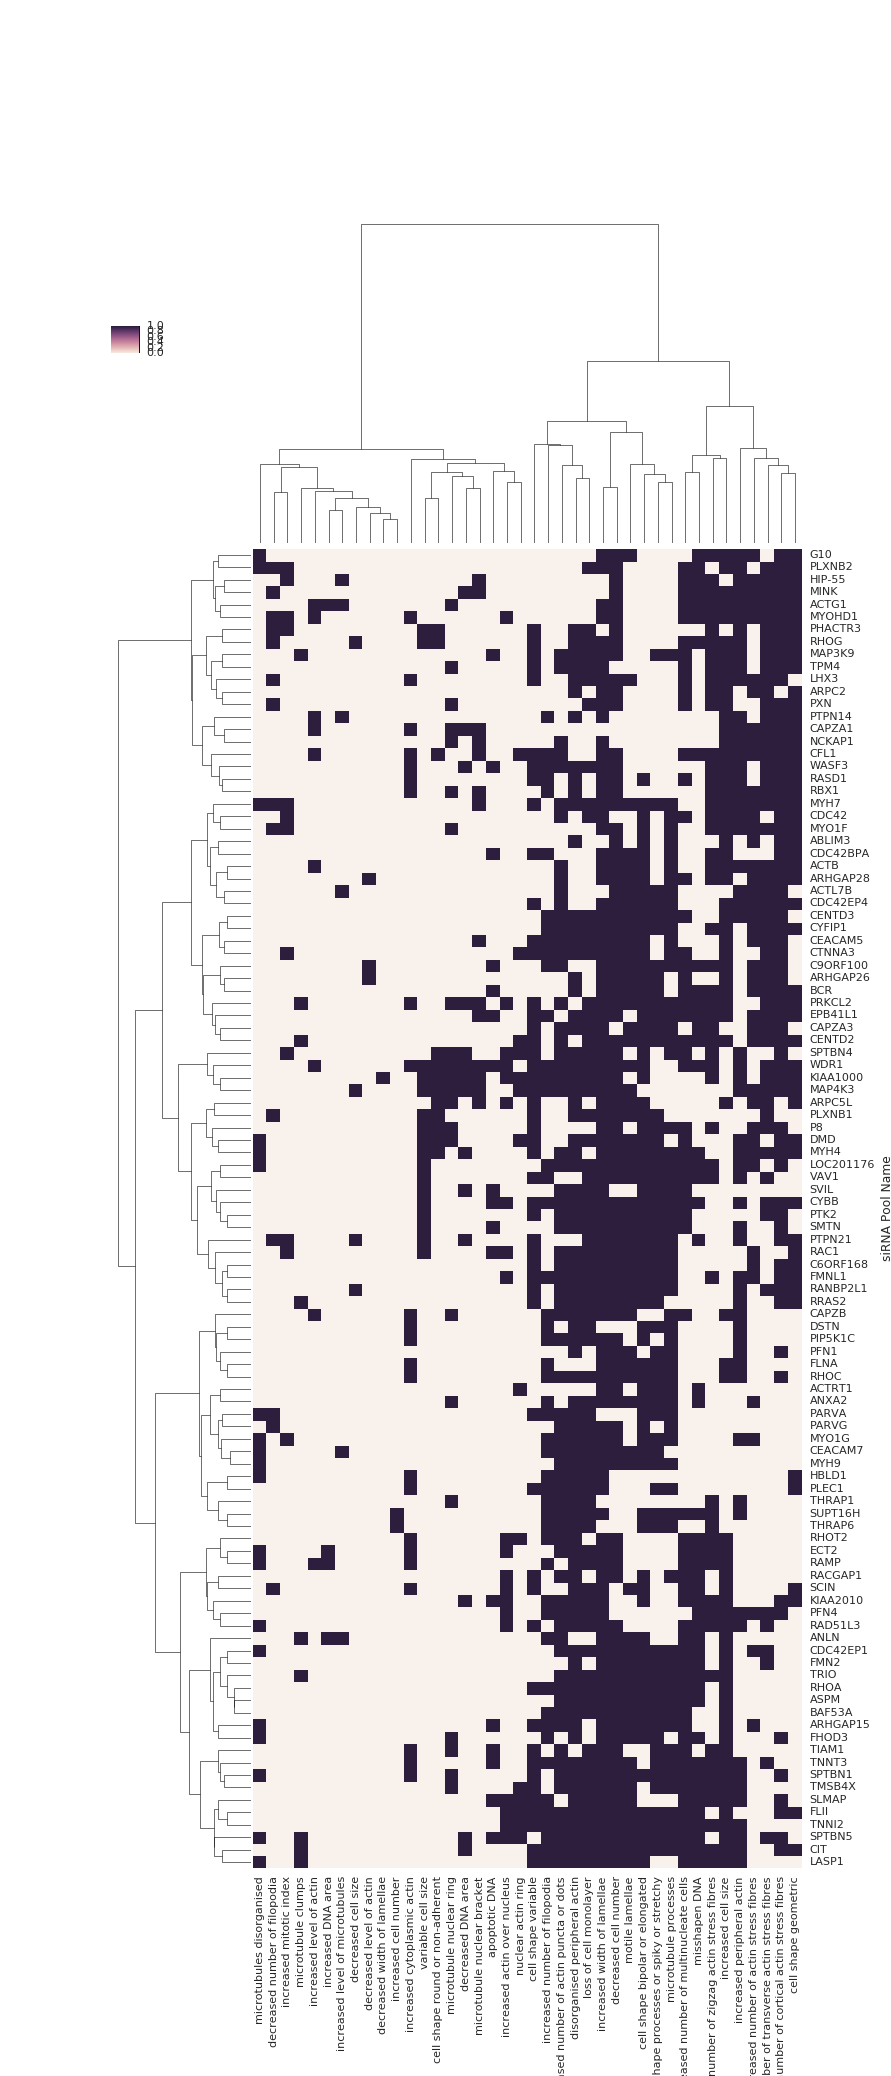

In [216]:
cg=clustermap(phenMap,row_linkage=Z,col_linkage=Zt)
for item in cg.ax_heatmap.get_xticklabels():
    item.set_rotation(90)
for item in cg.ax_heatmap.get_yticklabels():
    item.set_rotation(0)


ERROR:omero.gateway:Failed to close rawPixelsStore
Traceback (most recent call last):
  File "/home/ubuntu/OMERO.server-5.1.4-ice35-b55/lib/python/omero/gateway/__init__.py", line 6458, in getTiles
    rawPixelsStore.close()
  File "/home/ubuntu/OMERO.server-5.1.4-ice35-b55/lib/python/omero/gateway/__init__.py", line 4291, in close
    self._obj.close(*args, **kwargs)
  File "/home/ubuntu/OMERO.server-5.1.4-ice35-b55/lib/python/omero_ServicesF_ice.py", line 254, in close
    return _M_omero.api.StatefulServiceInterface._op_close.invoke(self, ((), _ctx))
InternalException: exception ::omero::InternalException
{
    serverStackTrace = ome.conditions.InternalException:  Wrapped Exception: (org.hibernate.exception.GenericJDBCException):
could not insert: [ome.model.meta.Event]
	at org.hibernate.exception.SQLStateConverter.handledNonSpecificException(SQLStateConverter.java:140)
	at org.hibernate.exception.SQLStateConverter.convert(SQLStateConverter.java:128)
	at org.hibernate.exception.JDBC

<IPython.core.display.Javascript object>


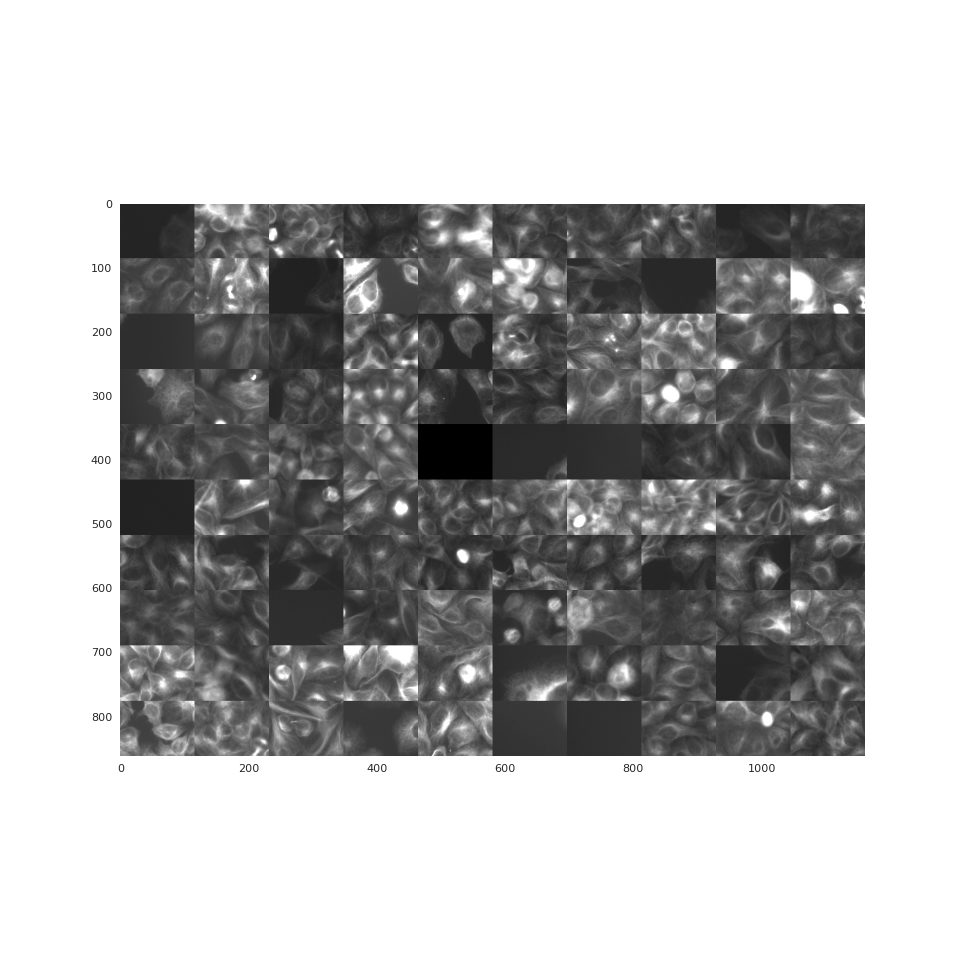

In [270]:
#a gallery of tiles for a bunch of phenotypes

conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
connected = conn.connect()

#ph=25
X=[  0, 580, 116, 348, 232, 464]
Y=[  0, 348,  87, 174, 261]
ni=10
w=116
h=86
phs=range(20,30)
tiles=np.zeros((h,w,len(phs)*ni))
for ph,kk in zip(phs,range(len(phs))):
    print ph
    ws=dfRhonAnn[dfRhonAnn['BoolPhenotype '+str(ph)]].Well
    for ii in range(ni):
        we=random.choice(ws.values)
        we=conn.getObject('Well',we)
        i=we.getImage()   
        x=random.choice(X)
        y=random.choice(Y)
        #print x,y,w,h,i.getId()
        try:
            tiles[:,:,ii+kk*ni] =getRohnTile(i.getId(),x,y,w,h,chan=1)
        except:
            continue

plt.figure(figsize=(12,12))
imc=buildComposite(tiles,len(phs),ni)
plt.grid(False)
plt.imshow(imc)
    

In [341]:
a=dfRhonAnn[dfRhonAnn['BoolPhenotype 31']]['siRNA Pool Name'].unique()
s2wph=s2w[s2w['siRNA Pool Name'].apply(lambda(x): x in a)]
for pln in s2wph.PLATE:
    fin=os.path.join(scratchDataDir,pln+'_features'+'.h5')
    S=HDFStore(fin)
    for ser in s2wph[s2wph.PLATE==pln].SERIES.unique():
        C=S.select('wndcharm',where='series==ser')
    S.close()

TypeError: cannot pass a where specification when reading from a Fixed format store. this store must be selected in its entirety

In [282]:
C=S.select('df',where='series==')


AttributeError: 'NoneType' object has no attribute 'read_column'

In [335]:
s2wph.head()

,Unnamed: 0,PLATE,SERIES,WELL,FIELD,imIds,annotations,siRNA Pool Name
1392,1392,Plate1_Actinome1,204,C24,1,109410,{'Phenotype 6 Term Accession URL': 'http://www...,EPB41L1
1393,1393,Plate1_Actinome1,205,C24,2,109411,{'Phenotype 6 Term Accession URL': 'http://www...,EPB41L1
1394,1394,Plate1_Actinome1,206,C24,3,109412,{'Phenotype 6 Term Accession URL': 'http://www...,EPB41L1
1569,1569,Plate1_Actinome1,381,F11,1,109281,{'Phenotype 2 Term Name': 'increased cortical ...,SLMAP
1570,1570,Plate1_Actinome1,382,F11,2,109282,{'Phenotype 2 Term Name': 'increased cortical ...,SLMAP


In [338]:
df.head()

,c,h,img_path,name,series,t,version,w,x,y,...,zernike_coefficients_wavelet_edge_62,zernike_coefficients_wavelet_edge_63,zernike_coefficients_wavelet_edge_64,zernike_coefficients_wavelet_edge_65,zernike_coefficients_wavelet_edge_66,zernike_coefficients_wavelet_edge_67,zernike_coefficients_wavelet_edge_68,zernike_coefficients_wavelet_edge_69,zernike_coefficients_wavelet_edge_70,zernike_coefficients_wavelet_edge_71
0,0,86,/uod/idr/filesets/idr0008-rohn-actinome/origin...,Plate9_Actinome1_0,0,0,3.2,116,0,0,...,0.005600,0.001713,0.315349,0.174237,0.013061,0.024441,0.006715,0.005789,0.005398,0.001830
1,2,86,/uod/idr/filesets/idr0008-rohn-actinome/origin...,Plate9_Actinome1_0,0,0,3.2,116,580,348,...,0.005116,0.003318,0.306421,0.207982,0.097434,0.007607,0.006663,0.000389,0.006078,0.003618
2,2,85,/uod/idr/filesets/idr0008-rohn-actinome/origin...,Plate9_Actinome1_0,0,0,3.2,116,116,435,...,0.001694,0.001728,0.189003,0.152148,0.130075,0.012755,0.007321,0.002813,0.002018,0.002532
3,2,85,/uod/idr/filesets/idr0008-rohn-actinome/origin...,Plate9_Actinome1_0,0,0,3.2,116,348,435,...,0.010711,0.003435,0.163617,0.123897,0.113751,0.011176,0.001724,0.002122,0.009450,0.002958
4,2,85,/uod/idr/filesets/idr0008-rohn-actinome/origin...,Plate9_Actinome1_0,0,0,3.2,116,580,435,...,0.003543,0.001638,0.143837,0.092664,0.106865,0.010219,0.004742,0.010730,0.003509,0.000305


## Stuff

In [8]:
pln='Plate10_Actinome1'
s2w[(s2w.PLATE==pln)].iloc[9].annotations

"{'siRNA Catalog Number': 'D-007290-01', 'Gene Identifier URL': 'http://www.ncbi.nlm.nih.gov/nuccore/NM_005470', 'siRNA Pool Name': 'ABI1', 'siRNA Identifier': 'ABI1-01', 'Gene Identifier': 'NM_005470'}"

In [81]:
distances, indices = nbrs.kneighbors(qry)

In [83]:
indices

array([[11945, 40182,  7862, 26907, 35467, 31497,  3119, 27295, 15635,
        17221, 35528, 12220]])

In [233]:
X=df.x.unique()
Y=df.y.unique()

In [237]:
X=[  0, 580, 116, 348, 232, 464]
Y=[  0, 348, 435,  87, 174, 261]


In [377]:
a=['pixel' in x for x in df.columns.values]

In [382]:
df[[u'pixel_intensity_statistics_00',u'pixel_intensity_statistics_01']]

,pixel_intensity_statistics_00,pixel_intensity_statistics_01
0,1103.824779,450.0
1,992.481556,956.0
2,1177.677789,1138.0
3,1147.277079,1104.0
4,1153.408316,1107.0
5,1404.584603,947.5
6,1670.108661,1140.0
7,1339.783079,575.5
8,1270.209102,782.5
9,1858.081395,1468.5


In [372]:
df.columns.values

array([u'c', u'h', u'img_path', ...,
       u'zernike_coefficients_wavelet_edge_69',
       u'zernike_coefficients_wavelet_edge_70',
       u'zernike_coefficients_wavelet_edge_71'], dtype=object)